In [4]:
import numpy as np
import pandas as pd
from google.colab import auth
# statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
#load randomforest regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

auth.authenticate_user()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
df=pd.read_csv('/content/drive/MyDrive/kurly_hackathon/data/data_ver2.csv')
df.head()

,user_id,purchae_price_sum,view_cnt,cart_cnt,purchase_cnt,conversion_rate,product_cnt,session_cnt,Recency,Frequency,Monetary,product_variable
0,512877624,1721.80,43,8,10,0.163934,9,1,11.700938,1,1721.80,-2.387171
1,522210904,899.79,185,7,8,0.040000,3,1,1.874664,1,899.79,-1.394514
2,540334105,6361.08,157,59,34,0.136000,34,1,0.519109,1,6361.08,-0.167557
3,526004290,3243.48,40,8,16,0.250000,13,1,1.638021,1,3243.48,1.268478
4,562432917,18832.82,96,19,24,0.172661,22,1,13.713229,1,18832.82,-2.083574


In [18]:
'''
vif 계산 
input: features list
output:vif
'''
def compute_vif(considered_features):    
    X = df[considered_features]
    X['intercept'] = 1
    
    # vif 저장하는 데이터프레임 생성 
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [19]:
df.columns

Index(['user_id', 'purchae_price_sum', 'view_cnt', 'cart_cnt', 'purchase_cnt',
       'conversion_rate', 'product_cnt', 'session_cnt', 'Recency', 'Frequency',
       'Monetary', 'product_variable'],
      dtype='object')

In [20]:
considered_features = ['cart_cnt', 'purchase_cnt','conversion_rate', 'session_cnt', 'Recency', 'Frequency', 'Monetary',"product_variable"]

# vif 계산 
compute_vif(considered_features).sort_values('VIF', ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,Variable,VIF
1,purchase_cnt,1.651514
0,cart_cnt,1.602776
6,Monetary,1.268962
2,conversion_rate,1.224822
4,Recency,1.072731
3,session_cnt,1.043050
7,product_variable,1.002632
5,Frequency,0.000000


### vif 값이 5 이상이면 다중공선성 있다고 가정 
### vif 5 이상인 변수 하나씩 제거

In [ ]:
considered_features.remove('product_cnt')
compute_vif(considered_features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,Variable,VIF
0,view_cnt,1.526688
1,cart_cnt,2.769652
2,purchase_cnt,4.390418
3,conversion_rate,1.490011
4,session_cnt,1.218710
5,Recency,1.042514
6,Frequency,0.000000
7,Monetary,2.177908


### 기존의 종속변수에서 purchase_price_sum, product_cnt 제거함



### 랜덤 포레스트 활용한 변수 선택 
- 구매금액을 종속 변수로 설정 
- Monetary 변수 제외한 나머지 변수를 독립 변수로 설정 

In [21]:
features=['cart_cnt', 'purchase_cnt','conversion_rate', 'session_cnt', 'Recency', 'Frequency', 'Monetary',"product_variable"]
target_feature='purchae_price_sum'
X=df.loc[:, features]
y=df.loc[:, target_feature]

In [22]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

In [23]:
rf = RandomForestRegressor(random_state=0)

rf.fit(X_train,y_train)

RandomForestRegressor(random_state=0)

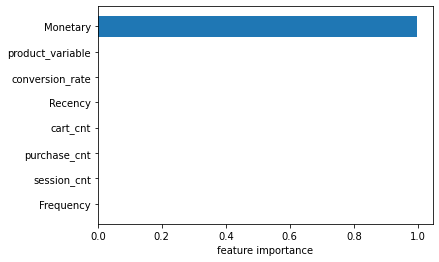

In [28]:
f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.xlabel("feature importance")
plt.show()

In [25]:
rfe = RFECV(rf,cv=5,scoring="neg_mean_squared_error")

rfe.fit(X_train,y_train)

RFECV(cv=5, estimator=RandomForestRegressor(random_state=0),
      scoring='neg_mean_squared_error')

In [26]:
selected_features = np.array(features)[rfe.get_support()]

In [27]:
selected_features

array(['Monetary'], dtype='<U16')